## Cold Atom integration into Qiskit demo notebook

In this notebook we will explore the typical workflow of how a user can communicate with the NaLi machine in Heidelberg as an example of how to integrate remote backends into Qiskit.

A schematic of this is shown in the figure below. Red parts in the pseudocode highlight new classes and functionalities which we showcase in this notebook while yellow indicates where we can use existing classes from Qiskit without further modification. 
\
Blue dashed arrows indicate all points where requests are sent form the user to the backend url, while green dashed arrows symbolise the response to those requests. The remote backend in the diagram is simulated here with a mock API built in flask running on the localhost.
\
A simple pip install qiskit should install all the required packages from Qiskit.

![](workflow_overview.png )



# I: Loading the backend

Let's first import the provider which manages the access to the backends. We print the list of available backends. 

In [1]:
from cold_atom_provider import ColdAtomProvider 

provider = ColdAtomProvider('token')
backend_list = provider.backends() 

print(backend_list)

[<CoherentSpinsDevice('SYNQS_NaLi_spins_backend')>, <CoherentSpinsSimulator('coherent_spin_qubits')>]


We select the `CoherentSpinsDevice` backend and take a look at the configuration of this backend:

In [2]:
backend = provider.get_backend('SYNQS_NaLi_spins_backend')
config_dict = backend.configuration().to_dict()

import pprint
pprint.pprint(config_dict)

{'atomic_species': ['na'],
 'backend_name': 'SYNQS_NaLi_spins_backend',
 'backend_version': '0.0.1',
 'basis_gates': ['rLx', 'rLz', 'rLz2'],
 'conditional': False,
 'coupling_map': [[]],
 'credits_required': False,
 'description': 'Setup of a cold atomic mixtures experiment with qudits.',
 'display_name': 'NaLi',
 'dynamic_reprate_enabled': False,
 'gates': [{'coupling_map': [[0], [1], [2], [3], [4]],
            'description': 'Evolution under the Z gate',
            'name': 'rLz',
            'parameters': ['delta'],
            'qasm_def': 'gate rLz(delta) {}'},
           {'coupling_map': [[0], [1], [2], [3], [4]],
            'description': 'Evolution under the Z2 gate',
            'name': 'rLz2',
            'parameters': ['chi'],
            'qasm_def': 'gate rLz2(chi) {}'},
           {'coupling_map': [[0], [1], [2], [3], [4]],
            'description': 'Evolution under the X gate',
            'name': 'rLx',
            'parameters': ['omega'],
            'qasm_def': 'gate

This configuration file tells us all we need to know about the backend. In particular, it communicates to the user which gate instructions it will accept in a circuit, how many wires the circuit can have etc. We also see the url on which it is running through the ssh.

# II: Building the quantum circuit

Here we demostrate how to build a quantum circuit for a cold atom device using the cold atom gate library and the `get_empty_circuit` method of the backend. This empty circuit will be initialized with the correct quantum and classical registers for the backend device. In this case there are 5 wires that represent the 5 trapping sites of the sodium BECs and a classical register to later bind the measurements to.

In [3]:
circuit = backend.get_empty_circuit()

print("Quantum registers in the circuit: ", circuit.qregs)
print("Classical registers in the circuit: ", circuit.cregs)
circuit.draw()

Quantum registers in the circuit:  [QuantumRegister(5, 'na')]
Classical registers in the circuit:  [ClassicalRegister(5, 'c5')]


na_0: 
      
na_1: 
      
na_2: 
      
na_3: 
      
na_4: 
      
c5: 5/

In [4]:
print(type(circuit))

<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>


We can now add gates from the library to this empty circuit and use qiskits `.draw` method for now. We aim to implement our own circuit drawer that more nicely differentiates between the two atomic species. 

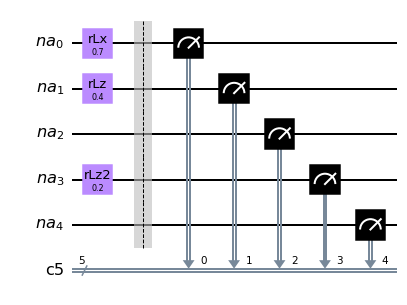

In [5]:
from gate_library import LXGate, LZGate, LZ2Gate

circuit.append(LXGate(omega=0.7), qargs=[0])
circuit.append(LZGate(delta=0.4), qargs=[1])
circuit.append(LZ2Gate(chi=0.2), qargs=[3])
circuit.barrier()
circuit.measure(range(5), range(5))
circuit.draw(output = 'mpl')

The circuit can also be built up from scratch without calling `get_empty_circuit`.

The gates can also be added to the circuit in a shorthand notation using `circuit.lx`, `circuit.lz` or `circuit.lz2`.

We demostrate this here for a minimal list of circuits that measure Rabi oscillations by applying the Rx gate with increasingly large angles:

### Example: Rabi circuit

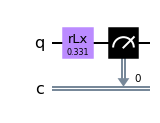

In [6]:
import numpy as np
from qiskit import QuantumCircuit

rabi_list = []

angles = np.linspace(0, 2*np.pi, 20)

for i, omega in enumerate(angles):
    circuit = QuantumCircuit(1, 1)    
    circuit.lx(omega, 0)
    circuit.measure(0, 0)
    rabi_list.append(circuit)

rabi_list[1].draw(output='mpl')

Other circuits of interest are Ramsey sequences involving the `Rz` gate and spin-squeezing dynamics induced by the `RZ2` gate:

### Example: Ramsey

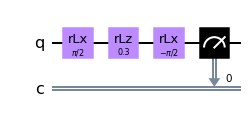

In [7]:
import gate_library

ramsey_circ = QuantumCircuit(1, 1)

ramsey_circ.lx(np.pi/2, 0)
ramsey_circ.lz(0.3, 0)
ramsey_circ.lx(-np.pi/2, 0)

ramsey_circ.measure(0, 0)

ramsey_circ.draw(output = 'mpl')

### Example: Spin squeezing

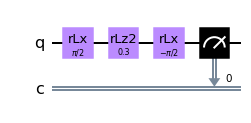

In [8]:
squeez_circ = QuantumCircuit(1, 1)

squeez_circ.lx(np.pi/2, 0)
squeez_circ.lz2(0.3, 0)
squeez_circ.lx(-np.pi/2, 0)
squeez_circ.measure(0, 0)

squeez_circ.draw(output = 'mpl')

This circuit can be converted into a Json payload that is sent to the backend server with the `circuit_to_cold_atom` method:

In [9]:
from circuit_to_cold_atom import circuit_to_cold_atom

pprint.pprint(circuit_to_cold_atom(squeez_circ, backend))

{'experiment_0': {'instructions': [('rLx', [0], [1.5707963267948966]),
                                   ('rLz2', [0], [0.3]),
                                   ('rLx', [0], [-1.5707963267948966]),
                                   ('measure', [0], [])],
                  'num_wires': 1,
                  'shots': 60}}


Under the `instructions` key, there is now a tuple for each instruction in the circuit. The first element is the name of that instruction, while the second element lists the indices of the wires that the instruction acts on. The last element of that tuple gives the value of the prameters of that instruction (if any). 

This function will complain if the gates used do not match the backend. Let's try to add a gate that is not support, such as the Hadamard gate:

In [10]:
circuit_wrong = backend.get_empty_circuit()

circuit_wrong.h(0)

# uncommenting this will create an error
# circuit_to_cold_atom(circuit_wrong, backend)

## III. Sending the circuit to the backend

We can now send this circuit to the backend. This creates a `ColdAtomJob` object. 

In [11]:
job = backend.run(squeez_circ, shots=10)
print(type(job))

<class 'cold_atom_job.ColdAtomJob'>


The remote backend has created a `job_id`, which serves as a unique identifier for this job:

In [12]:
print(job._job_id)

20210408_144212_70c2c


If we try to run a job that exceeds the maximum number of experiments or the number of shots that the backend allows, an error will be caused before the job is sent to the backend:

In [13]:
job_wrong = backend.run(rabi_list)

QiskitError: 'SYNQS_NaLi_spins_backend allows for max. 3 different circuits; 20 circuits were given '

In [14]:
job_wrong2 = backend.run(squeez_circ, shots = 100)

QiskitError: 'SYNQS_NaLi_spins_backend allows for max. 60 shots per circuit; 100 shots were requested'

## IV: Checking for status 

The remote backend now will process this job further, including putting it into a Queue and finally executing it and storing the results.
The backend does not automatically return the measurement status or result to the user.
Rather it is the user that has to make all requests. 

To check whether the job has finished, is running, or placed in the queue, Qiskit provides a `status` function. Right now, this returns an ERROR, because this is not yet implemented on the backend side. 

In [15]:
print(job.status())

JobStatus.ERROR


## V: Retrieving the result from the backend

To access the results of our circuit, we have to ask the backend for it. Internally the backend checks the `job_id` of the job and looks up the stored measurement outcomes. The backend then returns a Json dictionary which includes all information about the measurements and is turned into a `Qiskit.Result` object.

Currently, the result will timeout after a sepcified time of waiting for a viable result. 

In [16]:
result = job.result(timeout = 10)

JobTimeoutError: 'Timed out waiting for result'

## VI: Processing the result

To be continued.